In [ ]:
anvar/public_datasets/preproc_study/schw/4b_n4
/data/private_data/schw/schw_4b_n4

In [24]:
# ! cd /data/private_data/schw/schw_4b_n4/images && ls

In [28]:
from glob import glob
len(glob('/data_anvar/public_datasets/preproc_study/schw/4d_susan/*/T1_SEG.nii.gz')), len(glob('/data/private_data/schw/schw_4b_n4/images/*gz'))

(242, 242)

In [10]:
!cd /data_anvar/public_datasets/preproc_study/schw/3a_atlas/VS-SEG-001 && ls

T1.nii.gz  T1_SEG.nii.gz  T2.nii.gz


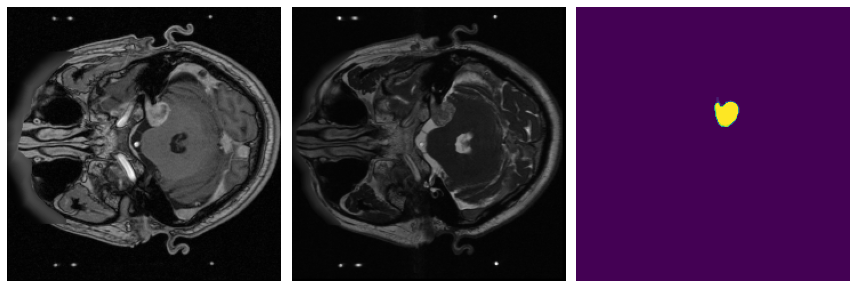

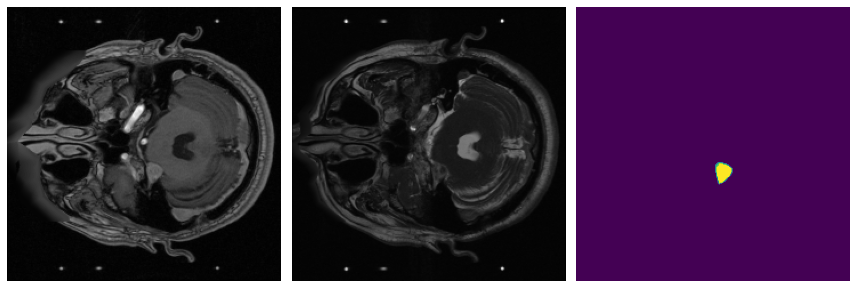

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 2, 80
data = sorted(glob("/data_anvar/public_datasets/preproc_study/schw/2a_interp/*/T1_SEG.nii.gz"))
for i in range(n):
    fname = data[i].split("/")[-2]
    t1 = nib.load(f"/data_anvar/public_datasets/preproc_study/schw/2a_interp/{fname}/T1.nii.gz").get_fdata().astype(np.float32)
    t2 = nib.load(f"/data_anvar/public_datasets/preproc_study/schw/2a_interp/{fname}/T2.nii.gz").get_fdata().astype(np.float32)
    label = nib.load(f"/data_anvar/public_datasets/preproc_study/schw/2a_interp/{fname}/T1_SEG.nii.gz").get_fdata().astype(np.float32)
    z = np.argsort(label.sum(axis=(0,1)))[-1:]
#     print(label.shape), print(t1.shape), print(t2.shape)
#     print(np.unique(label))
    imgs = [t1[:, :, z]]  + [t2[:, :, z]] + [label[:, :, z]]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
    for i in range(3):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()

In [30]:
import json
import os
from glob import glob
from glob2 import glob
from subprocess import call
import time

import nibabel
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

def load_nifty(directory, example_id, suffix):
    return nibabel.load(f'{directory}/{suffix}.nii.gz')


def load_channels(d, example_id):
    return [load_nifty(d, example_id, suffix) for suffix in ["T1", "T2"]]


def get_data(nifty, dtype="int16"):
    if dtype == "int16":
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0
        return data
    return nifty.get_fdata().astype(np.uint8)


def prepare_nifty(d, d_out):
    sub = d.split("/")[-1]
    t1, t2 = load_channels(d, sub)
    affine, header = t1.affine, t1.header
    vol = np.stack([get_data(t1), get_data(t2)], axis=-1)
    vol = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
#     print('l')
#     print( os.path.join(d_out, sub + ".nii.gz"))
    nibabel.save(vol, os.path.join(d_out, sub + ".nii.gz"))
#     print(glob(f'{d}/{sub}/**/MASK.nii.gz')[0])
    if os.path.exists(f'{d}/T1_SEG.nii.gz'):
        seg = load_nifty(d, sub, "T1_SEG")
        affine, header = seg.affine, seg.header
        vol = get_data(seg, "unit8")
#         vol[vol == 4] = 3
#         mask = np.zeros(vol.shape, dtype=np.uint8)
#         mask[vol == 2] = 1
#         mask[vol == 3] = 2
#         mask[vol == 1] = 3
        seg = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
#         print(os.path.join(d_out, sub + "_seg.nii.gz"))
        nibabel.save(seg, os.path.join(d_out, sub + "_seg.nii.gz"))


def prepare_dirs(d_out, train):
    img_path, lbl_path = os.path.join(d_out, "images"), os.path.join(d_out, "labels")
    call(f"mkdir {img_path}", shell=True)
    if train:
        call(f"mkdir {lbl_path}", shell=True)
    dirs = glob(os.path.join(d_out, "*"))
    for d in dirs:
        if '.nii.gz' in d:
                if "T1" in d or "T2" in d:
                    continue
                if "_seg" in d:
                    call(f"mv {d} {lbl_path}", shell=True)
                else:
                    call(f"mv {d} {img_path}", shell=True)
                
#         call(f"rm -rf {d}", shell=True)
         

def prepare_dataset_json(d_out, train):
    images, labels = glob(os.path.join(d_out, "images", "*")), glob(os.path.join(d_out, "labels", "*"))
    images = sorted([img.replace(d_out + "/", "") for img in images])
    labels = sorted([lbl.replace(d_out + "/", "") for lbl in labels])
    
    modality = {"0": "T1", "1": "T2"}
    labels_dict = {"0": "background", "1": "edema"}
    if train:
        key = "training"
        data_pairs = [{"image": img, "label": lbl} for (img, lbl) in zip(images, labels)]
    else:
        key = "test"
        data_pairs = [{"image": img} for img in images]

    dataset = {
        "labels": labels_dict,
        "modality": modality,
        key: data_pairs,
    }

    with open(os.path.join(d_out, "dataset.json"), "w") as outfile:
        json.dump(dataset, outfile)


def run_parallel(func, args):
    return Parallel(n_jobs=os.cpu_count())(delayed(func)(arg) for arg in args)


def prepare_dataset(data, train, out):
    print(f"Preparing GBM dataset from: {data}")
    d_out = out
    if not os.path.exists(d_out):
        call(f"mkdir {d_out}", shell=True)
    start = time.time()
#     run_parallel(prepare_nifty, sorted(glob(os.path.join(data, "*"))))
    for each in tqdm(sorted(glob(os.path.join(data, "*")))):
        if os.path.exists(os.path.join(each, "T1_SEG.nii.gz")):
            prepare_nifty(each, d_out)
    prepare_dirs(d_out, train)
    prepare_dataset_json(d_out, train)
    end = time.time()
    print(f"Preparing time: {(end - start):.2f}")


In [31]:
prepare_dataset('/data_anvar/public_datasets/preproc_study/schw/4d_susan/',True, '/data/private_data/schw/schw_4d_susan')

Preparing GBM dataset from: /data_anvar/public_datasets/preproc_study/schw/4d_susan/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [10:22<00:00,  2.56s/it]


Preparing time: 632.07


In [2]:
!cd /data/private_data/schw && rm -r 33_3d

In [113]:
!python3 ../preprocess.py --data /data/private_data/schw/ --task 37 --ohe --exec_mode training --results /data/private_data/schw/

Preprocessing /data/private_data/schw/schw_3a_atlas
(2, 155, 240, 240)
(155, 240, 240)
(2, 155, 240, 240)
(155, 240, 240)
(2, 155, 218, 219)
[[  0   7   9]
 [155 225 228]
 [155 240 240]
 [155 218 219]]
(2, 155, 240, 240)
(155, 240, 240)
(2, 155, 212, 214)
[[  0  12  20]
 [155 224 234]
 [155 240 240]
 [155 212 214]]
(2, 155, 240, 240)
(155, 240, 240)
(2, 155, 240, 240)
(155, 240, 240)
(2, 155, 240, 240)
(155, 240, 240)
(2, 155, 240, 240)
[[  0   0   0]
 [155 240 240]
 [155 240 240]
 [155 240 240]]
(2, 155, 240, 238)
[[  0   0   0]
 [155 240 238]
 [155 240 240]
 [155 240 238]]
(2, 155, 217, 216)
(2, 155, 220, 213)
[[  0   3  18]
 [155 223 231]
 [155 240 240]
 [155 220 213]]
[[  0   6  12]
 [155 223 228]
 [155 240 240]
 [155 217 216]]
(2, 155, 240, 240)
(155, 240, 240)
(2, 155, 240, 240)
(155, 240, 240)
(2, 155, 224, 222)
[[  0   7  10]
 [155 231 232]
 [155 240 240]
 [155 224 222]]
(2, 155, 225, 220)
[[  0   2  11]
 [155 227 231]
 [155 240 240]
 [155 225 220]]
(2, 155, 240, 240)
(155, 240

In [4]:
# !cd /data/private_data/schw/33_3d && ls

VS-SEG-001
(210, 210, 180, 1)
[0 1]
(210, 210, 180, 3)


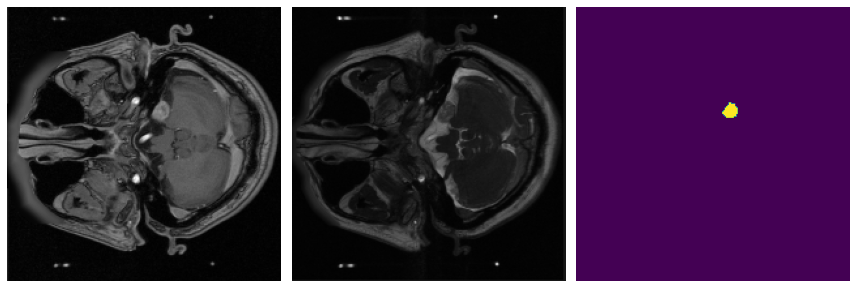

VS-SEG-002
(210, 210, 180, 1)
[0 1]
(210, 210, 180, 3)


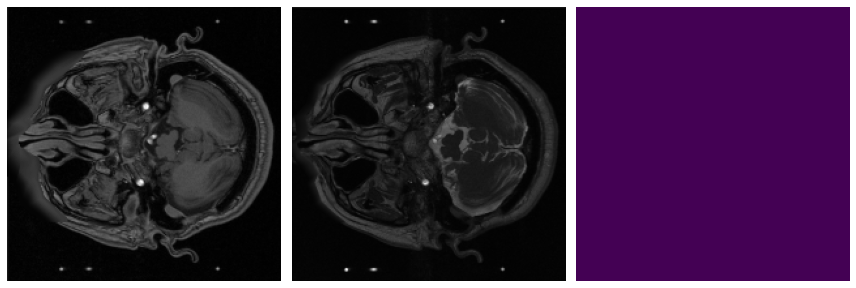

VS-SEG-003
(210, 210, 180, 1)
[0 1]
(210, 210, 180, 3)


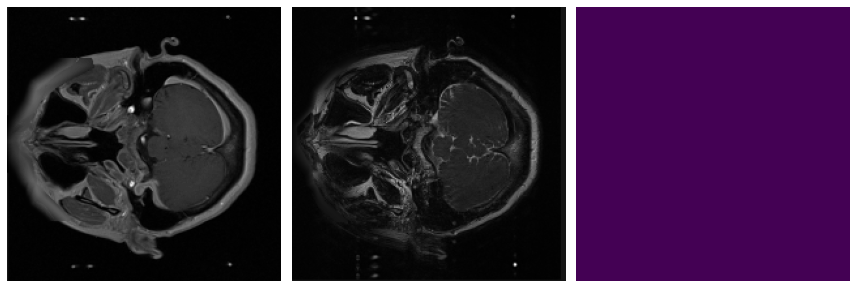

VS-SEG-004
(210, 210, 180, 1)
[0 1]
(210, 210, 180, 3)


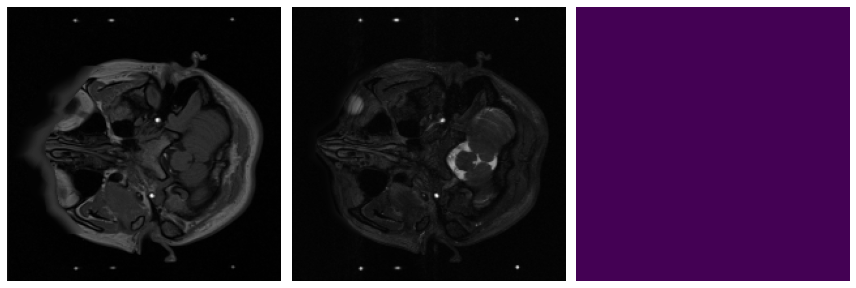

VS-SEG-005
(210, 210, 180, 1)
[0 1]
(210, 210, 180, 3)


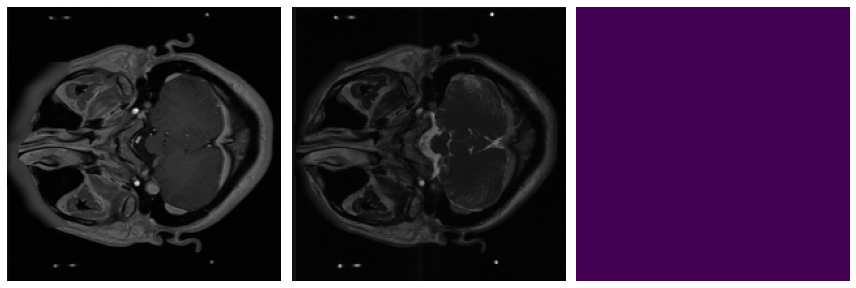

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 5, 40
data = sorted(glob("/data/private_data/schw/schw_4b_n4/images/*.nii.gz"))
for i in range(n):
    fname = data[i].split("/")[-1].split(".")[0]
    print(fname)
    img = np.load(f"/data/private_data/schw/41_3d/{fname}_x.npy").astype(np.float32).transpose(3,2,1,0)
    label = np.load(f"/data/private_data/schw/41_3d/{fname}_y.npy").astype(np.uint8).transpose(3,2,1,0)
#     pred = np.round(pred, 0).transpose(3,2,1,0)
#     print(label.sum(axis=(0,1)))
#     print(np.argsort(label.sum(axis=(0,1))))
#     z = np.argsort(label.sum(axis=(1,2)))[-1:]
#     print(z[-1:])
    print(label.shape), print(np.unique(label))
    print(img.shape)
    imgs = [img[:, :, z,i] for i in [0, 1]] + [label[:, :, z, 0]]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
    for i in range(3):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()

In [71]:
for i in range(1,  1):
    print(check)

In [73]:
import pickle


with open('/data/private_data/schw/33_3d/config.pkl', 'rb') as f:
    data = pickle.load(f)

In [74]:
data

{'patch_size': [128, 128, 128],
 'spacings': [1.0, 1.0, 1.0],
 'n_class': 1,
 'in_channels': 3}

In [12]:
import pandas as pd
df = pd.read_csv('/results/schw_infer/schw_1_reg/metrics_schw_1_reg_fold-1.csv')

In [17]:
!cd /results/schw_results/schw_1_reg/fold-1/checkpoints && ls

'best_epoch=35-dice_mean=84.36.ckpt'  'epoch=43-dice_mean=85.35.ckpt'
'best_epoch=48-dice_mean=86.94.ckpt'  'epoch=44-dice_mean=81.65.ckpt'
'best_epoch=73-dice_mean=88.84.ckpt'  'epoch=45-dice_mean=80.62.ckpt'
'epoch=17-dice_mean=77.00.ckpt'       'epoch=46-dice_mean=82.77.ckpt'
'epoch=19-dice_mean=77.26.ckpt'       'epoch=48-dice_mean=86.94.ckpt'
'epoch=20-dice_mean=72.53.ckpt'       'epoch=68-dice_mean=88.47.ckpt'
'epoch=22-dice_mean=73.50.ckpt'       'epoch=73-dice_mean=88.84.ckpt'
'epoch=31-dice_mean=75.53.ckpt'       'epoch=74-dice_mean=88.14.ckpt'
'epoch=34-dice_mean=83.55.ckpt'       'epoch=77-dice_mean=88.47.ckpt'
'epoch=35-dice_mean=84.36.ckpt'       'epoch=81-dice_mean=88.30.ckpt'
'epoch=36-dice_mean=83.99.ckpt'        last.ckpt
'epoch=38-dice_mean=82.28.ckpt'       'oldbest_epoch=19-dice_mean=77.26.ckpt'
'epoch=40-dice_mean=83.46.ckpt'


In [13]:
df.mean()

Unnamed: 0             NaN
Ids                    NaN
Dice_1Hausdorff95_1    NaN
Sensitivity_1          NaN
Specificity_1          NaN
Surface_dice_1         NaN
Precision_1            NaN
dtype: object

In [42]:
i_t = nib.load('/data/private_data/schw/schw_1_reg/labels/VS-SEG-001_seg.nii.gz')

In [43]:
i_t.shape

(512, 512, 120)

In [53]:
import os
import sys
import argparse
import numpy as np
import torch
import pandas as pd
import nibabel as nib    
from pathlib import Path
from surface_distance import metrics
from tqdm import tqdm
import torch.nn as nn


def sensitivity_and_specificity(mask_gt, mask_pred):
    """ Computes sensitivity and specificity
     sensitivity  = TP/(TP+FN)
     specificity  = TN/(TN+FP) """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    tp = (mask_gt & mask_pred).sum()
    tn = (~mask_gt & ~mask_pred).sum()
    fp = (~mask_gt & mask_pred).sum()
    fn = (mask_gt & ~mask_pred).sum()
#     TP/(TP+FP) - precision; TP/(TP+FN) - recall
    return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)


def calculate_metrics_brats(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids','Dice_1'
                'Hausdorff95_1',
                'Sensitivity_1',
               'Specificity_1',
               'Surface_dice_1',
               'Precision_1']
    
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    #class 1
    distances = metrics.compute_surface_distances((true_mask==1), (pred_mask[0,:,:,:]==1), spaces)
    df.at[0,'Dice_1'] = metrics.compute_dice_coefficient((true_mask==1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Surface_dice_1'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec = sensitivity_and_specificity((true_mask==1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Sensitivity_1'] = sens
    df.at[0,'Precision_1'] = precision
    df.at[0,'Specificity_1'] = spec
    return df


def calculate_metrics(path_to_pred, path_to_target, spaces = [1,1,1], out = '/home/polina/glioma/all_dice_metrics.csv'  ):
    
    """ 
    - path_to_pred - path to folder with predict subjects
    - path_to_target - path to folder with target subjects
    - name_pred - name for prediction, ex -brainTumorMask_SRI.nii.gz
    - name_target - name for targets, ex -GTV_to_SRI.nii.gz
    - spaces - if false - [1,1,1]
    - name_csv - name files for each subjects
    - path_csv_all - path to the main file with metrics for each subjects
    """
    _columns = ['Ids','Dice_1'
                'Hausdorff95_1',
                'Sensitivity_1',
               'Specificity_1',
               'Surface_dice_1',
               'Precision_1']
    
    af_all = pd.DataFrame(columns = _columns)
    pred_folder = Path(path_to_pred)
    target_folder = Path(path_to_target)
    for ids in tqdm(os.listdir(pred_folder)):
        sub = ids[:-8]
        targets = nib.load(target_folder /  f'{sub}_seg.nii.gz')
        spaces = targets.header.get_zooms()
#         print(spaces)
        targets = targets.get_fdata()
#         y_wt, y_tc, y_et = targets > 0, ((targets == 1) + (targets == 3)) > 0, targets == 3
#         targets = np.stack([y_wt, y_tc, y_et], axis=0).astype(int)
        predictions = np.load((os.path.join(path_to_pred, ids)), allow_pickle=True)['arr_0']
#         pred = nn.functional.interpolate(torch.from_numpy(predictions), size=tuple([23,  0,  0]), mode="trilinear", align_corners=True)
        pred = np.round(predictions, 0)
        pred = np.transpose(pred, (0, 3, 2, 1))
#         print(targets.shape), print(np.unique(targets))
#         print(pred.shape), print(np.unique(pred))
        df=calculate_metrics_brats(targets.astype('int'), pred.astype('int'), sub, spaces)
#         print(df)
        af_all = af_all.append(df)
    af_all.to_csv(out)  
    print(af_all.mean())

    


In [60]:
import pandas as pd
metr = pd.read_csv('/results/schw_infer/schw_1_reg/metrics_schw_1_reg_fold-1.csv')
metr.mean()

Unnamed: 0             NaN
Ids                    NaN
Dice_1Hausdorff95_1    NaN
Sensitivity_1          NaN
Specificity_1          NaN
Surface_dice_1         NaN
Precision_1            NaN
dtype: object

In [64]:
calculate_metrics('/results/schw_infer/schw_3a_atlas/predictions_best_epoch=75-dice_mean=87_13_task=37_fold=0_tta','/data/private_data/schw/schw_3a_atlas/labels', spaces=[1.0, 1.0, 1.0], out = '/results/schw_infer/schw_3a_atlas/metrics_epoch_75-dice_87_13_task=37_fold_0_.CSV')

  2%|██▋                                                                                                                                                            | 4/242 [00:02<02:47,  1.42it/s]/tmp/ipykernel_16769/4141623058.py:24: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [02:55<00:00,  1.38it/s]

Dice_1Hausdorff95_1         NaN
Sensitivity_1          0.567635
Specificity_1          0.999998
Surface_dice_1         0.781336
Precision_1            0.963655
Dice_1                 0.685699
Hausdorff95_1               inf
dtype: float64


In [69]:
calculate_metrics('/results/schw_infer/schw_3a_atlas/predictions_best_epoch=75-dice_mean=87_13_task=37_fold=0_tta','/data/private_data/schw/schw_3a_atlas/labels', spaces=[1.0, 1.0, 1.0], out = '/results/schw_infer/schw_3a_atlas/metrics_epoch_75-dice_87_13_task=37_fold_0_.CSV')

  2%|███▉                                                                                                                                                           | 4/161 [00:02<01:21,  1.94it/s]/tmp/ipykernel_16769/4141623058.py:24: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [01:22<00:00,  1.94it/s]

Dice_1Hausdorff95_1         NaN
Sensitivity_1          0.578476
Specificity_1          0.999997
Surface_dice_1         0.795392
Precision_1            0.965552
Dice_1                 0.697301
Hausdorff95_1               inf
dtype: float64


In [71]:
calculate_metrics('/results/schw_infer/schw_3a_atlas/predictions_best_epoch=75-dice_mean=87_13_task=37_fold=0_tta','/data/private_data/schw/schw_3a_atlas/labels', spaces=[1.0, 1.0, 1.0], out = '/results/schw_infer/schw_3a_atlas/metrics_epoch_75-dice_87_13_task=37_fold_0_.CSV')

  2%|███▉                                                                                                                                                            | 2/81 [00:01<00:42,  1.86it/s]/tmp/ipykernel_16769/4141623058.py:24: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:42<00:00,  1.93it/s]

Dice_1Hausdorff95_1         NaN
Sensitivity_1          0.546062
Specificity_1          0.999999
Surface_dice_1         0.753403
Precision_1            0.959859
Dice_1                 0.662610
Hausdorff95_1               inf
dtype: float64


In [ ]:
calculate_metrics('/results/schw_infer/schw_4a_resamp/predictions_best_epoch=87-dice_mean=89_19_task=39_fold=2_tta','/data/private_data/schw/schw_4a_resamp/labels', spaces=[1.0, 1.0, 1.0], out = '/results/schw_infer/schw_4a_resamp/metrics_epoch_87-dice_89_19_task_39_fold_2')

 27%|███████████████████████████████████████████                                                                                                                   | 66/242 [00:30<01:21,  2.15it/s]/tmp/ipykernel_16769/4141623058.py:24: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)
 31%|█████████████████████████████████████████████████▌                                                                                                            | 76/242 [00:34<01:17,  2.14it/s]

In [72]:
!cd /data/private_data/schw/schw_3a_atlas && ls

33_3d  37_3d  41_3d  schw_1_reg      schw_3a_atlas   schw_4b_n4
36_3d  39_3d  42_3d  schw_2a_interp  schw_4a_resamp  schw_4d_susan


(215, 230, 155)
(215, 230, 155, 3)
[0 1]
[34]
(215, 230, 155)
(215, 230, 155, 3)
[0 1]
(240, 240, 155, 1)
[0 1]


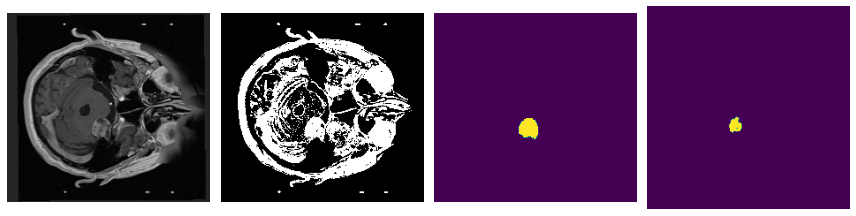

In [82]:

import ants
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
fname = 'VS-SEG-010'
img_orig = np.load(f"/data/private_data/schw/37_3d/{fname}_x.npy").transpose(3,2,1,0)
label_orig = np.load(f"/data/private_data/schw/37_3d/{fname}_y.npy").transpose(0,3,2,1).squeeze()
# label_orig = nib.load(f"/data/private_data/6_histogram_fold_1/labels/{fname}_seg.nii.gz")
print(label_orig.shape), print(img_orig.shape)
print(np.unique(label_orig))
# spaces = label_orig.header.get_zooms()
# print(spaces)
# label_orig = label_orig.get_fdata().astype(np.uint8)
l = np.argsort(label_orig.sum(axis=(0,1)))[-1:]
# label_orig = ants.reorient_image2(ants.from_numpy(label_orig), orientation = 'LAS').numpy() 
# y_wt, y_tc, y_et = label_orig > 0, ((label_orig == 1) + (label_orig == 3)) > 0, label_orig == 3
# label_orig = np.stack([y_wt, y_tc, y_et], axis=0).astype(int).transpose(1,2,3,0)
print(l)
pred = np.load(f'/results/schw_infer/schw_3a_atlas/predictions_best_epoch=75-dice_mean=87_13_task=37_fold=0_tta/{fname}.npy.npz')['arr_0']
p = np.round(pred, 0).transpose(3,2,1,0).astype(np.uint8)
print(label_orig.shape), print(img_orig.shape)
print(np.unique(label_orig))
print(p.shape), print(np.unique(p))
# print(mask.shape), print(np.unique(mask))
# print((p[:,:,:,0]* mask).shape)
# check = np.concatenate(((p[:,:,:,0]* mask)[:,:,:,np.newaxis], (p[:,:,:,1]* mask)[:,:,:,np.newaxis], (p[:,:,:,2]* mask)[:,:,:,np.newaxis]), axis=3)
# print(check.shape), print(np.unique(check))
imgs = [img_orig[:, :, l, i] for i in [0,2]] + [label_orig[:,:,l]]  +[p[:,:,l,0]] 
 
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
for i in range(4):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
plt.tight_layout()            
plt.show()

(215, 230, 155)
(215, 230, 155, 3)
[0 1]
[34]
(215, 230, 155)
(215, 230, 155, 3)
[0 1]
(240, 240, 155, 1)
[0 1]


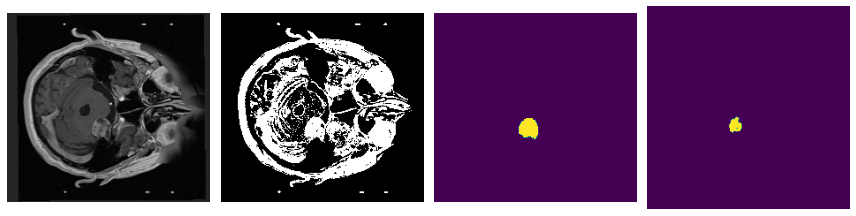

In [102]:
from scipy.special import expit, softmax
import ants
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
fname = 'VS-SEG-010'
img_orig = np.load(f"/data/private_data/schw/37_3d/{fname}_x.npy").transpose(3,2,1,0)
label_orig = np.load(f"/data/private_data/schw/37_3d/{fname}_y.npy").transpose(0,3,2,1).squeeze()
# label_orig = nib.load(f"/data/private_data/schw/schw_3a_atlas/labels/{fname}_seg.nii.gz")
# print(label_orig.header["pixdim"][1:4].tolist()[::-1])
# label_orig = label_orig.get_fdata().astype(np.uint8)
print(label_orig.shape), print(img_orig.shape)
print(np.unique(label_orig))
# spaces = label_orig.header.get_zooms()
# print(spaces)
# label_orig = label_orig.get_fdata().astype(np.uint8)
l = np.argsort(label_orig.sum(axis=(0,1)))[-1:]
# label_orig = ants.reorient_image2(ants.from_numpy(label_orig), orientation = 'LAS').numpy() 
# y_wt, y_tc, y_et = label_orig > 0, ((label_orig == 1) + (label_orig == 3)) > 0, label_orig == 3
# label_orig = np.stack([y_wt, y_tc, y_et], axis=0).astype(int).transpose(1,2,3,0)
print(l)
pred = np.load(f'/results/schw_infer/schw_3a_atlas/predictions_best_epoch=75-dice_mean=87_13_task=37_fold=0_tta/{fname}.npy.npz')['arr_0']
p = np.round(pred, 0).transpose(3,2,1,0).astype(np.uint8)
print(label_orig.shape), print(img_orig.shape)
print(np.unique(label_orig))
print(p.shape), print(np.unique(p))
# print(mask.shape), print(np.unique(mask))
# print((p[:,:,:,0]* mask).shape)
# check = np.concatenate(((p[:,:,:,0]* mask)[:,:,:,np.newaxis], (p[:,:,:,1]* mask)[:,:,:,np.newaxis], (p[:,:,:,2]* mask)[:,:,:,np.newaxis]), axis=3)
# print(check.shape), print(np.unique(check))
imgs = [img_orig[:, :, l, i] for i in [0,2]] + [label_orig[:,:,l]]  +[p[:,:,l,0]] 
 
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
for i in range(4):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
plt.tight_layout()            
plt.show()

In [105]:
met = np.load('/data/private_data/22_3d/TCGA-02-0087_meta.npy')
print(met[2]), print(met[3])

[155 240 240]
[155 240 227]


(None, None)

In [99]:
meta = np.load(f"/data/private_data/schw/37_3d/{fname}_meta.npy")

In [100]:
min_d, max_d = meta[0, 0], meta[1, 0]
min_h, max_h = meta[0, 1], meta[1, 1]
min_w, max_w = meta[0, 2], meta[1, 2]
# n_class, original_shape, cropped_shape = pred.shape[0], meta[2], meta[3]
#             if not all(cropped_shape == pred.shape[1:]):
#                 resized_pred = np.zeros((n_class, *cropped_shape))
#                 for i in range(n_class):
#                     resized_pred[i] = resize(
#                         pred[i], cropped_shape, order=3, mode="edge", cval=0, clip=True, anti_aliasing=False
#                     )
#                 pred = resized_pred
#             final_pred = np.zeros((n_class, *original_shape))
#             final_pred[:, min_d:max_d, min_h:max_h, min_w:max_w] = pred

In [101]:
print(meta[2]), print(meta[3])

[155 240 240]
[155 230 215]


(None, None)

In [114]:
!cd /results/schw_infer/schw_3a_atlas/predictions_best_epoch=75-dice_mean=87_13_task=37_fold=0_tta && ls

VS-SEG-010.npy.npz  VS-SEG-011.npy.npz	VS-SEG-015.npy.npz


In [116]:
!cd /results/schw_infer/schw_3a_atlas/predictions_best_epoch=75-dice_mean=87_13_task=37_fold=0_tta_old_full_dataset && ls

VS-SEG-001.npy.npz  VS-SEG-063.npy.npz	VS-SEG-125.npy.npz  VS-SEG-189.npy.npz
VS-SEG-002.npy.npz  VS-SEG-064.npy.npz	VS-SEG-126.npy.npz  VS-SEG-190.npy.npz
VS-SEG-003.npy.npz  VS-SEG-065.npy.npz	VS-SEG-127.npy.npz  VS-SEG-191.npy.npz
VS-SEG-004.npy.npz  VS-SEG-066.npy.npz	VS-SEG-128.npy.npz  VS-SEG-192.npy.npz
VS-SEG-005.npy.npz  VS-SEG-067.npy.npz	VS-SEG-129.npy.npz  VS-SEG-193.npy.npz
VS-SEG-006.npy.npz  VS-SEG-068.npy.npz	VS-SEG-131.npy.npz  VS-SEG-194.npy.npz
VS-SEG-007.npy.npz  VS-SEG-069.npy.npz	VS-SEG-132.npy.npz  VS-SEG-195.npy.npz
VS-SEG-008.npy.npz  VS-SEG-070.npy.npz	VS-SEG-133.npy.npz  VS-SEG-196.npy.npz
VS-SEG-009.npy.npz  VS-SEG-071.npy.npz	VS-SEG-134.npy.npz  VS-SEG-197.npy.npz
VS-SEG-010.npy.npz  VS-SEG-072.npy.npz	VS-SEG-135.npy.npz  VS-SEG-198.npy.npz
VS-SEG-011.npy.npz  VS-SEG-073.npy.npz	VS-SEG-136.npy.npz  VS-SEG-199.npy.npz
VS-SEG-012.npy.npz  VS-SEG-074.npy.npz	VS-SEG-137.npy.npz  VS-SEG-200.npy.npz
VS-SEG-013.npy.npz  VS-SEG-075.npy.npz	VS-SEG-138.npy.npz  VS-SE

(240, 240, 155)
(1, 240, 240, 155)
[0 1]
[33]
[49]


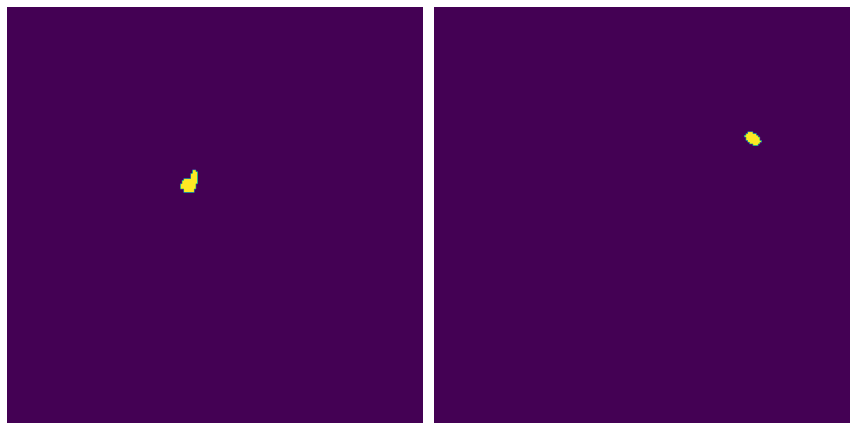

TypeError: unsupported operand type(s) for &: 'ANTsImage' and 'bool'

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
#  VS-SEG-002_seg.nii.gz
sub = 'VS-SEG-004'
n, z = 1, 80
for i in range(n):
    pred_sub = f'/results/schw_infer/schw_3a_atlas/predictions_best_epoch=75-dice_mean=87_13_task=37_fold=0_tta_old_full_dataset/{sub}.npy.npz'
#     orig_folder = f'/data_anvar/public_datasets/preproc_study/schw/orig/{sub}/T1_SEG.nii.gz'
#     resample_folder = f'/data_anvar/public_datasets/preproc_study/schw/4a_resamp/{sub}/T1_SEG.nii.gz'
#     reg_1 = f'/data_anvar/public_datasets/preproc_study/schw/1_reg/{sub}/T1_SEG.nii.gz'
    targets = ants.image_read(f'/data/private_data/schw/schw_3a_atlas/labels/{sub}_seg.nii.gz')
#     targets = ants.reorient_image2(targets, orientation = 'LAI').numpy().astype('int')
    print(targets.shape)
    data = np.load(pred_sub, allow_pickle=True)['arr_0']
#     prediction = pred_invert_resample_1cl(data, reg_1, resample_folder)
    prediction = np.round(data, 0).astype('int').transpose(0,3,2,1)
    print(prediction.shape), print(np.unique(prediction))
#     label_k = ants.image_read(f'/data_anvar/public_datasets/preproc_study/schw/1_reg_check/{sub}/T1_SEG.nii.gz')
#     label_k = ants.reorient_image2(label_k, orientation = 'LAI').numpy().astype('int')
#     label_k = nib.load('/data_anvar/public_datasets/preproc_study/schw/1_reg_check/VS-SEG-157/T1_SEG.nii.gz').get_fdata().astype('int')
#     label_p = nib.load('/data/private_data/schw/schw_1_reg/labels/VS-SEG-157_seg.nii.gz').get_fdata().astype('int')
#     label_orig = ants.image_read(orig_folder)
#     label_orig = ants.reorient_image2(label_orig, orientation = 'LAI').numpy().astype('int')
#     label_orig = nib.load(orig_folder).get_fdata().astype('int')
    z = np.argsort(targets.sum(axis=(0,1)))[-1:]
    p = np.argsort(prediction[0].sum(axis=(0,1)))[-1:]
    print(z)
    print(p)
    imgs =  [targets[:,:,z]] + [prediction[0,:, :, 49]]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
    for i in range(2):
        ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()
    
print(metrics.compute_dice_coefficient((targets==1), (prediction==1)))
distances = metrics.compute_surface_distances((targets==1), (prediction==1), [1,1,1])
print(metrics.compute_surface_dice_at_tolerance(distances,1))

(215, 230, 155)
(215, 230, 155, 3)
[0 1]
[34]
(215, 230, 155)
(215, 230, 155, 3)
[0 1]
(240, 240, 155, 1)
[0 1]


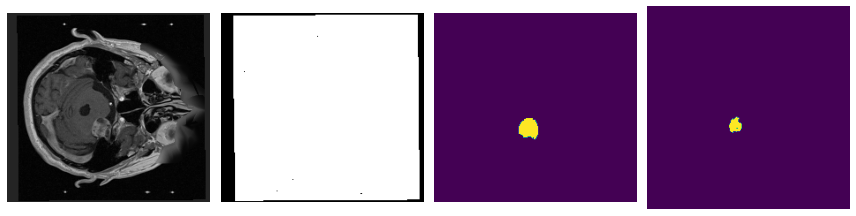

In [134]:
from scipy.special import expit, softmax
import ants
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
fname = 'VS-SEG-010'
img_orig = np.load(f"/data/private_data/schw/37_3d/{fname}_x.npy").transpose(3,2,1,0)
label_orig = np.load(f"/data/private_data/schw/37_3d/{fname}_y.npy").transpose(0,3,2,1).squeeze()
# label_orig = nib.load(f"/data/private_data/schw/schw_3a_atlas/labels/{fname}_seg.nii.gz")
# print(label_orig.header["pixdim"][1:4].tolist()[::-1])
# label_orig = label_orig.get_fdata().astype(np.uint8)
print(label_orig.shape), print(img_orig.shape)
print(np.unique(label_orig))
# spaces = label_orig.header.get_zooms()
# print(spaces)
# label_orig = label_orig.get_fdata().astype(np.uint8)
l = np.argsort(label_orig.sum(axis=(0,1)))[-1:]
# label_orig = ants.reorient_image2(ants.from_numpy(label_orig), orientation = 'LAS').numpy() 
# y_wt, y_tc, y_et = label_orig > 0, ((label_orig == 1) + (label_orig == 3)) > 0, label_orig == 3
# label_orig = np.stack([y_wt, y_tc, y_et], axis=0).astype(int).transpose(1,2,3,0)
print(l)
pred = np.load(f'/results/schw_infer/schw_3a_atlas/predictions_best_epoch=75-dice_mean=87_13_task=37_fold=0_tta_old_full_dataset/{fname}.npy.npz')['arr_0']
p = np.round(pred, 0).transpose(3,2,1,0).astype(np.uint8)
print(label_orig.shape), print(img_orig.shape)
print(np.unique(label_orig))
print(p.shape), print(np.unique(p))
# print(mask.shape), print(np.unique(mask))
# print((p[:,:,:,0]* mask).shape)
# check = np.concatenate(((p[:,:,:,0]* mask)[:,:,:,np.newaxis], (p[:,:,:,1]* mask)[:,:,:,np.newaxis], (p[:,:,:,2]* mask)[:,:,:,np.newaxis]), axis=3)
# print(check.shape), print(np.unique(check))
imgs = [img_orig[:, :, l, i] for i in [0,2]] + [label_orig[:,:,l]]  +[p[:,:,l,0]] 
 
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
for i in range(4):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
plt.tight_layout()            
plt.show()